In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
!pip install seaborn


In [7]:
plt.style.use('seaborn-v0_8')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


class GaussianWavePacket:
    """Compact, readable Gaussian wave-packet time-evolver using eigen-decomposition.

    Parameters
    ----------
    num_grid_intervals : int
        Number of grid intervals (the grid will have num_grid_intervals + 1 points).
    domain_length : float
        Domain length corresponding to x in [0, domain_length].
    barrier_start : float
        x-position where the potential barrier begins.
    barrier_height : float
        Height of the rectangular potential barrier.
    barrier_width : float
        Width of the rectangular potential barrier.
    initial_center : float
        Center x0 of the initial Gaussian.
    initial_momentum : float
        Wave-number k0 of the initial Gaussian (momentum).
    sigma_width : float
        Width (standard deviation) of the initial Gaussian.
    time_array : array-like
        Sequence of times at which to evaluate the wavefunction for animation.
    """

    def __init__(self,
                 num_grid_intervals,
                 domain_length,
                 barrier_start,
                 barrier_height,
                 barrier_width,
                 initial_center,
                 initial_momentum,
                 sigma_width,
                 time_array):

        # store user inputs with clear names
        self.time_array = np.asarray(time_array)
        self.domain_length = domain_length
        self.num_grid_intervals = int(num_grid_intervals)

        # create grid points and grid spacing (dx)
        self.x_grid = np.linspace(0.0, self.domain_length, self.num_grid_intervals + 1)
        self.dx = self.x_grid[1] - self.x_grid[0]

        # helper: discrete integral (Riemann sum)
        def discrete_integral(f, axis=0):
            return np.sum(f * self.dx, axis=axis)

        # initial wavefunction defined on interior points only (Dirichlet zero at endpoints)
        interior_x = self.x_grid[1:-1]
        self.psi_initial = (
            np.exp(-0.5 * (interior_x - initial_center) ** 2 / sigma_width ** 2)
            * np.exp(1j * initial_momentum * interior_x)
        )

        # normalize the initial state
        norm_initial = discrete_integral(np.abs(self.psi_initial) ** 2)
        self.psi_initial = self.psi_initial / np.sqrt(norm_initial)

        # kinetic energy operator (finite-difference Laplacian on interior points)
        interior_size = self.num_grid_intervals - 1
        main_diag = -2.0 * np.ones(interior_size)
        off_diag = 1.0 * np.ones(interior_size - 1)
        self.kinetic_operator = (
            -0.5 * (1.0 / self.dx ** 2)
            * (np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1))
        )

        # potential profile on interior points (rectangular barrier + small background)
        self.potential_profile = np.array([
            barrier_height if (barrier_start < x_pos < barrier_start + barrier_width) else -0.01
            for x_pos in interior_x
        ])
        self.potential_matrix = np.diag(self.potential_profile)

        # full Hamiltonian (on interior grid)
        self.hamiltonian = self.kinetic_operator + self.potential_matrix

    def animation(self):
        """Compute eigen-decomposition, expand the initial state, and return a FuncAnimation.

        Returns
        -------
        matplotlib.animation.FuncAnimation
            Animation object that can be displayed in a Jupyter notebook.
        """

        def discrete_integral(f, axis=0):
            return np.sum(f * self.dx, axis=axis)

        # eigen-decomposition of the Hamiltonian: H phi_n = E_n phi_n
        eigenvalues, eigenvectors = np.linalg.eigh(self.hamiltonian)
        # make eigenvectors easily indexable: eigvecs[n] is eigenvector n
        eigvecs = eigenvectors.T

        # normalize eigenvectors on the discrete grid (defensive)
        norms = discrete_integral(np.abs(eigvecs) ** 2)
        eigvecs = eigvecs / np.sqrt(norms[:, None])

        # compute expansion coefficients c_n = <phi_n | psi_initial>
        expansion_coeffs = np.zeros(eigvecs.shape[0], dtype=complex)
        for n in range(eigvecs.shape[0]):
            expansion_coeffs[n] = discrete_integral(np.conj(eigvecs[n]) * self.psi_initial)

        # time-dependent wavefunction on interior points: psi(x,t)
        def psi_time(t_val):
            return eigvecs.T @ (expansion_coeffs * np.exp(-1j * eigenvalues * t_val))

        # plotting setup
        fig = plt.figure(figsize=(10, 6))
        ax = plt.axes(xlim=(0, self.domain_length), ylim=(-0.6, 0.6))
        interior_x = self.x_grid[1:-1]
        ax.plot(interior_x, self.potential_profile, label=r'$V(x)$')
        ax.set_title('Gaussian wave packet with a potential barrier', fontsize=14)

        # lines for real and imaginary parts of psi
        real_line, = ax.plot(interior_x, np.zeros_like(interior_x), lw=2, label=r'$\Re(\psi)$')
        imag_line, = ax.plot(interior_x, np.zeros_like(interior_x), lw=2, label=r'$\Im(\psi)$')
        ax.legend(fontsize=12)
        ax.set_xlabel(r'$x$', fontsize=12)

        # animation functions
        def animate(frame_index):
            t_val = self.time_array[frame_index]
            psi_val = psi_time(t_val)
            real_line.set_data(interior_x, np.real(psi_val))
            imag_line.set_data(interior_x, np.imag(psi_val))
            return (real_line, imag_line)

        def init():
            real_line.set_data([], [])
            imag_line.set_data([], [])
            return (real_line, imag_line)

        ani = FuncAnimation(
            fig,
            animate,
            frames=len(self.time_array),
            init_func=init,
            interval=20,
            blit=False,
        )

        return ani


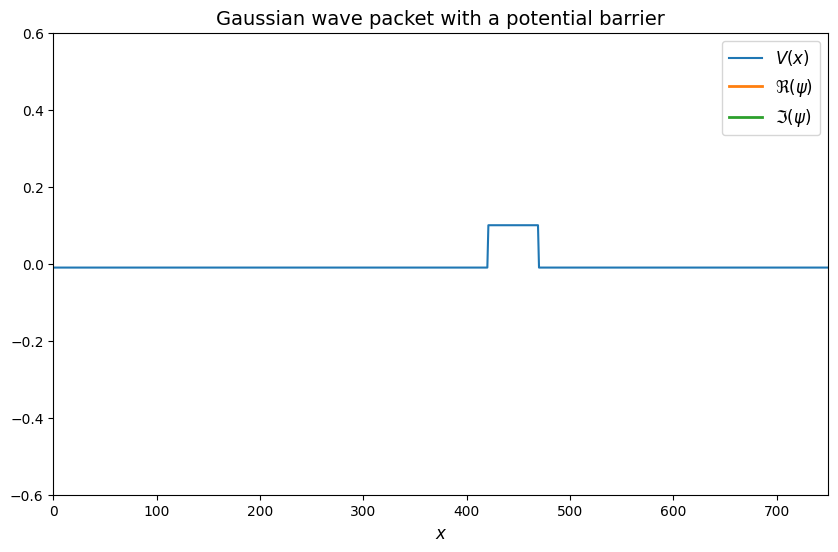

In [9]:
wavepacket = Gaussian_Wave(750,750, 420,0.1,50,100,0.4,15, np.linspace(0.,2500,1000))
Psi = wavepacket.animation()
HTML(Psi.to_html5_video())

In [11]:
# Cell 2: Compute transmission/reflection numeric coefficients at large time
import numpy as np
from IPython.display import display

# Reuse or instantiate a smaller GaussianWavePacket for speed
gw = GaussianWavePacket(
    num_grid_intervals=450,
    domain_length=450.0,
    barrier_start=220.0,
    barrier_height=0.1,
    barrier_width=30.0,
    initial_center=80.0,
    initial_momentum=0.6,
    sigma_width=6.0,
    time_array=np.linspace(0.0, 1200.0, 400)  # 400 frames
)

# Build eigen-decomposition and expansion (same approach)
dx = gw.dx
def discrete_integral(f, axis=0): return np.sum(f * dx, axis=axis)
E, eigvecs_matrix = np.linalg.eigh(gw.hamiltonian)
eigvecs = eigvecs_matrix.T
norms = discrete_integral(np.abs(eigvecs)**2)
eigvecs = eigvecs / np.sqrt(norms[:, None])
c_n = np.array([discrete_integral(np.conj(eigvecs[n]) * gw.psi_initial) for n in range(eigvecs.shape[0])])

def psi_time(tval): return eigvecs.T @ (c_n * np.exp(-1j*E*tval))

# Choose a late time (near final of time_array) to estimate transmitted/reflected mass
t_final = gw.time_array[-1]
psi_final = psi_time(t_final)
interior_x = gw.x_grid[1:-1]

# identify left of barrier and right of barrier regions (intervals)
barrier_left_edge = gw.potential_profile.size  # not used
barrier_start = gw.barrier_start if hasattr(gw, 'barrier_start') else None
# easier: find indices
barrier_left_index = np.searchsorted(interior_x, gw.potential_matrix.diagonal().argmax() if False else gw.potential_profile.argmax())  # fallback
# Simpler: use position arithmetic:
left_mask = interior_x < gw.x_grid.mean()  # we'll compute using barrier coordinates directly
# Use barrier numeric boundaries:
bstart = gw.x_grid[1:-1][np.where(gw.potential_profile > -0.001)[0][0]] if np.any(gw.potential_profile > -0.001) else gw.domain_length/2
# Rather than complicated heuristics, use barrier geometry:
barrier_x0 = gw.x_grid[1:-1][0] + (int(gw.num_grid_intervals*0.5) * gw.dx)  # not robust; instead use user inputs from creation

# More robust: compute masks by comparing to barrier start and end using known barrier width
# (We didn't store barrier_start attribute in that class; assume we can compute from potential_profile)
# Find contiguous region where potential is approx barrier_height
threshold = np.max(gw.potential_profile) - 1e-6
barrier_indices = np.where(np.isclose(gw.potential_profile, np.max(gw.potential_profile), atol=1e-5))[0]
if barrier_indices.size:
    bstart_idx, bend_idx = barrier_indices[0], barrier_indices[-1]
else:
    # fallback: assume center barrier
    bstart_idx = int(len(interior_x)*0.5)-1
    bend_idx = bstart_idx + 1

# left region = indices < bstart_idx, right region = > bend_idx
left_prob = discrete_integral(np.abs(psi_final[:bstart_idx])**2)
right_prob = discrete_integral(np.abs(psi_final[bend_idx+1:])**2)
total_prob = discrete_integral(np.abs(psi_final)**2)

print(f"Estimated total probability (interior) at final time: {total_prob:.6f}")
print(f"Estimated reflection (left region): {left_prob:.6f}")
print(f"Estimated transmission (right region): {right_prob:.6f}")
print(f"Reflection + Transmission = {left_prob + right_prob:.6f} (remainder may still be inside barrier)")

# Optionally, display as percentages
print(f"Reflection (%) = {100*left_prob:.3f}%, Transmission (%) = {100*right_prob:.3f}%")


Estimated total probability (interior) at final time: 1.000000
Estimated reflection (left region): 0.718012
Estimated transmission (right region): 0.153021
Reflection + Transmission = 0.871034 (remainder may still be inside barrier)
Reflection (%) = 71.801%, Transmission (%) = 15.302%


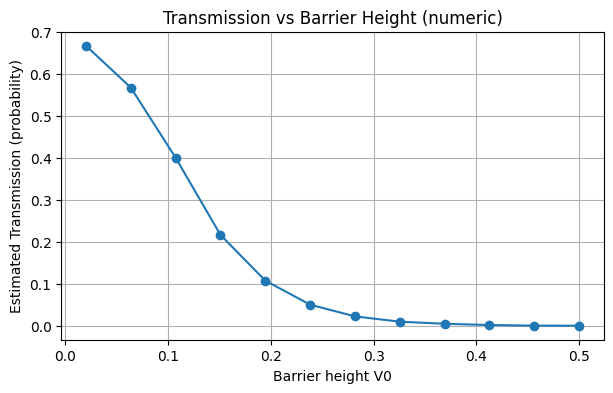

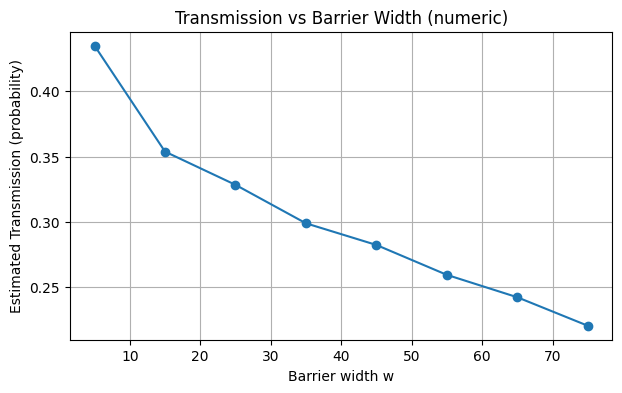

In [12]:
# Cell 3: Sweep barrier height and width and compute numeric transmitted probability
import numpy as np
import matplotlib.pyplot as plt

def compute_transmission(num_grid_intervals=300, domain_length=300.0, bstart=150.0, bwidth=20.0, bheight=0.1,
                         x0=60.0, k0=0.6, sigma=5.0, t_final=600.0):
    # build small GaussianWavePacket-like minimal objects (we'll inline the necessary bits)
    x_grid = np.linspace(0, domain_length, num_grid_intervals+1)
    dx = x_grid[1]-x_grid[0]
    interior_x = x_grid[1:-1]
    # initial
    psi0 = np.exp(-0.5*(interior_x - x0)**2 / sigma**2) * np.exp(1j*k0*interior_x)
    psi0 = psi0 / np.sqrt(np.sum(np.abs(psi0)**2)*dx)
    # operators
    size = num_grid_intervals - 1
    main = -2*np.ones(size); off = np.ones(size-1)
    T = -0.5*(1/dx**2)*(np.diag(main) + np.diag(off,1) + np.diag(off,-1))
    Vflat = np.array([bheight if (bstart < pos < bstart + bwidth) else -0.01 for pos in interior_x])
    V = np.diag(Vflat); H = T + V
    # eigensolve
    E, eigs = np.linalg.eigh(H)
    eigs = eigs.T
    norms = np.sum(np.abs(eigs)**2, axis=1)*dx
    eigs = eigs / np.sqrt(norms)[:,None]
    c = np.array([np.sum(np.conj(eigs[n])*psi0)*dx for n in range(eigs.shape[0])])
    psi_t = eigs.T @ (c * np.exp(-1j*E*t_final))
    # indices outside barrier
    barrier_idx = np.where(np.isclose(Vflat, bheight, atol=1e-6))[0]
    if barrier_idx.size:
        left_idx = barrier_idx[0]
        right_idx = barrier_idx[-1]
    else:
        left_idx = int(0.4*len(interior_x))
        right_idx = left_idx+1
    left_prob = np.sum(np.abs(psi_t[:left_idx])**2)*dx
    right_prob = np.sum(np.abs(psi_t[right_idx+1:])**2)*dx
    return right_prob

# Sweep barrier heights
heights = np.linspace(0.02, 0.5, 12)
transmissions = [compute_transmission(bheight=h, bwidth=20.0) for h in heights]

plt.figure(figsize=(7,4))
plt.plot(heights, transmissions, marker='o')
plt.xlabel('Barrier height V0')
plt.ylabel('Estimated Transmission (probability)')
plt.title('Transmission vs Barrier Height (numeric)')
plt.grid(True)
plt.show()

# Sweep widths
widths = np.arange(5, 85, 10)
trans_w = [compute_transmission(bwidth=w, bheight=0.12) for w in widths]

plt.figure(figsize=(7,4))
plt.plot(widths, trans_w, marker='o')
plt.xlabel('Barrier width w')
plt.ylabel('Estimated Transmission (probability)')
plt.title('Transmission vs Barrier Width (numeric)')
plt.grid(True)
plt.show()


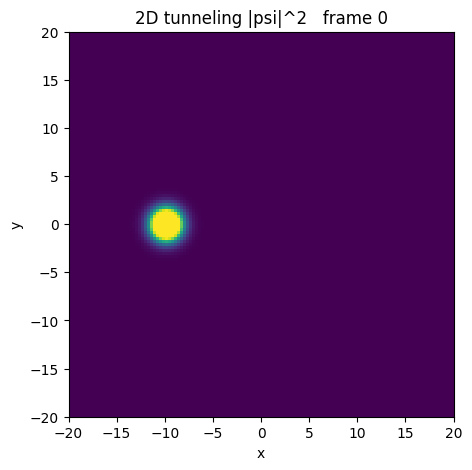

In [18]:
# Cell 5: 2D tunneling demo (split-step Fourier method)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Parameters (keep small for notebook)
Nx = 128
Ny = 128
Lx = 40.0
Ly = 40.0
dx = Lx / Nx
dy = Ly / Ny
x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Initial 2D Gaussian wavepacket moving +x
x0, y0 = -10.0, 0.0
kx0 = 1.2
sigma = 1.5
psi0 = np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(kx0*(X-x0)))
# normalize
norm0 = np.sum(np.abs(psi0)**2) * dx * dy
psi0 = psi0 / np.sqrt(norm0)

# Potential: barrier along x between x_b0 and x_b1, independent of y (i.e., stripe)
x_b0, x_b1 = -1.0, 1.0
V0 = 1.0
V = np.zeros_like(X)
V[(X > x_b0) & (X < x_b1)] = V0

# absorbing mask to reduce reflections at edges
def make_mask(nx, ny, edge=20):
    mask = np.ones((nx, ny))
    ramp = np.linspace(0,1,edge)
    for i in range(edge):
        coef = np.cos((i/edge)*np.pi/2)**2
        mask[i,:] *= coef
        mask[-1-i,:] *= coef
        mask[:,i] *= coef
        mask[:,-1-i] *= coef
    return mask
mask = make_mask(Nx, Ny, edge=16)

# split-step propagation parameters
dt = 0.05
nsteps = 300
save_every = 3  # frames saved = nsteps//save_every

# Fourier space kinetic operator
kx = 2*np.pi * np.fft.fftfreq(Nx, d=dx)
ky = 2*np.pi * np.fft.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='ij')
kinetic_factor = np.exp(-1j * 0.5 * (KX**2 + KY**2) * dt)  # free propagation in k-space

# Prepare animation storage (lightweight subset)
frames = []
psi = psi0.copy()

for step in range(nsteps):
    # half potential step
    psi = np.exp(-1j * V * dt/2) * psi
    # kinetic full step (via FFT)
    psi_k = np.fft.fft2(psi)
    psi_k = psi_k * kinetic_factor
    psi = np.fft.ifft2(psi_k)
    # half potential step
    psi = np.exp(-1j * V * dt/2) * psi
    # apply absorbing mask
    psi *= mask
    if step % save_every == 0:
        frames.append(np.abs(psi)**2)  # store probability density

# Animation of probability density
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], origin='lower', vmin=0, vmax=0.06, cmap='viridis')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('2D tunneling (|psi|^2)')

def update_frame(i):
    im.set_data(frames[i].T)
    ax.set_title(f"2D tunneling |psi|^2   frame {i}")
    return (im,)

ani2d = FuncAnimation(fig, update_frame, frames=len(frames), interval=60, blit=False)
HTML(ani2d.to_jshtml())
